# Create Lap Feature DataFrame and Model

In [1]:
import pandas as pd
import numpy as np
import datetime
import os
import scripts.f1_scripts  as f1

import statsmodels.api as sms
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

In [2]:
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

def assign_color(tire):
    colors = {'Ultra': 'm', 'Super': 'r', 'Soft': 'y', 'Medium': 'w', 'Hard': 'k', 'Intermediate': 'g'}
    return colors[tire]

def assign_ordinal(tire):
    vals = {'Ultra': 1, 'Super': 2, 'Soft': 3, 'Medium': 4, 'Hard': 5, 'Intermediate': 5}
    return vals[tire]

/Users/milesmonaghan/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
# Load driver list as GLOBAL variable
DRIVER_LIST = pd.read_csv('data/drivers.csv')

In [4]:
def create_race_features(filename):
    year, race_num, track = filename.split('_')
    # Load lap times for all drivers
    lap_data = pd.read_csv('data/lap_history/{filename}_lap_history.csv'.format(filename=filename), header=None)
    lap_times = f1.assign_lap(lap_data)
    lap_times['TIME'] = f1.convert_time(lap_times['TIME'])
    lap_times.sort_values(by=['NO', 'LAP'], inplace=True)
    lap_times['LAP'] = lap_times['LAP'].astype(int)

    # Load Tire strategy data
    tire_data = pd.read_csv('data/tire_strategy/{filename}.csv'.format(filename=filename))
    tire_strat = f1.get_tires(tire_data)

    # Join Driver, Name, No. to tire data and sort by No.
    tire_strat = pd.merge(DRIVER_LIST, tire_strat, on='NAME')
    tire_strat.drop(['NAME', 'DRIVER'], axis=1, inplace=True)

    # Append tire data to lap data
    mask = tire_strat.iloc[:,1:].notnull().values
    lap_times['TIRE'] = tire_strat[tire_strat.columns[1:]].values[mask].flatten()
    lap_times['TRACK'] = track
    lap_times['YEAR'] = year
    lap_times['RACE'] = race_num
    lap_times['GAP'] = lap_times['GAP'].apply(lambda x: x.strip())

    return lap_times


In [58]:
# Create a list of the available races to date that we can use for training
races = os.listdir('data/fia')
races = races[1:]
races;

In [6]:
# Create DataFrame of all laps for all drivers in all races
list_of_times = []
for race in races:
    lap_times = create_race_features(race)
    list_of_times.append(lap_times)
    print '{} complete.'.format(race)
all_lap_times = pd.concat(list_of_times)
all_lap_times['YEAR'] = all_lap_times['YEAR'].astype(int)
all_lap_times.reset_index(inplace=True, drop=True)



2015_10_hungary complete.
2015_11_belgium complete.
2015_12_italy complete.
2015_13_singapore complete.
2015_14_japan complete.
2015_15_russia complete.
2015_16_usa complete.
2015_17_mexico complete.
2015_18_brazil complete.
2015_19_abudhabi complete.
2015_1_australia complete.
2015_2_malaysia complete.
2015_3_china complete.
2015_4_bahrain complete.
2015_5_spain complete.
2015_6_monaco complete.
2015_7_canada complete.
2015_8_austria complete.
2015_9_britain complete.
2016_1_australia complete.
2016_2_bahrain complete.
2016_3_china complete.


In [7]:
all_lap_times[all_lap_times['LAP'] == 1].shape

(423, 8)

In [9]:
all_lap_times['SAFETY'] = all_lap_times.apply(lambda x: f1.assign_safety(x['TRACK'], x['YEAR'], x['LAP']), axis=1)


In [11]:
all_lap_times[all_lap_times['SAFETY'] == True].shape

(1362, 9)

## Add laps since tire change

In [60]:
all_lap_times.head()

,NO,GAP,TIME,LAP,TIRE,TRACK,YEAR,RACE,SAFETY
0,3,6.325,99.193,1,Soft,hungary,2015,10,0
1,3,8.887,91.382,2,Soft,hungary,2015,10,0
2,3,10.556,90.333,3,Soft,hungary,2015,10,0
3,3,12.451,89.962,4,Soft,hungary,2015,10,0
4,3,13.664,89.525,5,Soft,hungary,2015,10,0


In [ ]:
def assign_stint_lap(df):
    df['STINT_LAP'] = 1
    idx = df['GAP'] == 'PIT'
    for val in idx:
        

### Commented out cells used to debug loading the data

In [ ]:
# # Load driver list for particular season
# driver_list = pd.read_csv('data/drivers.csv')

# # Load lap times for all drivers
# filename = '2016_3_china'
# lap_data = pd.read_csv('data/lap_history/{filename}_lap_history.csv'.format(filename=filename), header=None)
# lap_times = f1.assign_lap(lap_data)
# lap_times['TIME'] = f1.convert_time(lap_times['TIME'])
# lap_times.sort_values(by=['NO', 'LAP'], inplace=True)
# lap_times.shape

In [ ]:
# # Load Tire strategy data
# tire_data = pd.read_csv('data/tire_strategy/{filename}.csv'.format(filename=filename))
# tire_strat = f1.get_tires(tire_data)
# tire_strat['NAME'].unique;

In [ ]:
# # Join Driver, Name, No. to tire data and sort by No.
# tire_strat = pd.merge(driver_list, tire_strat, on='NAME')
# tire_strat.drop(['NAME', 'DRIVER'], axis=1, inplace=True)
# tire_strat;

In [ ]:
# # Append tire data to lap data
# mask = tire_strat.iloc[:,1:].notnull().values
# # lap_times['TIRE'] = 
# tire_strat[tire_strat.columns[1:]].values[mask].flatten().shape
# # lap_times['TRACK'] = 'Australia'
# # lap_times['YEAR'] = 2016
# # lap_times['RACE'] = 1
# # lap_times

In [ ]:
# for num in lap_times['NO'].unique():
#     print num
#     print lap_times[lap_times['NO'] == num].shape

In [ ]:
# for num in lap_times['NO'].unique():
#     print num
#     print 'Laps: ',tire_strat.ix[tire_strat['NO'] == num].notnull().values.sum() - 1

## Remove Pit and Out laps

In [12]:
def remove_pits(df):
    idx = []
    previous = None
    for row in df.iterrows():
        if row[1]['GAP'] == 'PIT' or previous == 'PIT':
            idx.append(row[0])
        previous = row[1]['GAP']
    return df.drop(idx, axis=0)

In [13]:
no_pits = remove_pits(all_lap_times)
print all_lap_times.shape
print no_pits.shape

(23097, 9)
(21255, 9)


In [14]:
no_pits.drop(no_pits[no_pits['LAP'] == 1].index, axis=0, inplace=True)
no_pits.shape

(20896, 9)

In [16]:
no_safety = no_pits[no_pits['SAFETY'] == 0]
no_safety.shape

(19867, 9)

## Create average lap times by driver, race, tire

In [17]:
group1 = no_safety.drop(['GAP', 'LAP', 'RACE', 'SAFETY'], axis=1).groupby(['NO', 'TIRE', 'TRACK', 'YEAR'], as_index=False)
avg_laps = pd.merge(group1.count(), group1.mean(), how='left', on=['NO', 'TIRE', 'TRACK', 'YEAR'])
avg_laps.head()


,NO,TIRE,TRACK,YEAR,TIME_x,TIME_y
0,3,Hard,britain,2015,7,103.192714
1,3,Hard,japan,2015,48,100.632333
2,3,Hard,malaysia,2015,34,106.824735
3,3,Hard,spain,2015,22,92.014000
4,3,Intermediate,usa,2015,14,117.217643


In [18]:
group2 = no_safety[['NO', 'TIRE', 'TRACK', 'YEAR', 'TIME']].groupby(['NO', 'TIRE', 'TRACK', 'YEAR'])
std_laps = pd.merge(avg_laps, group2.std().reset_index(), how='left', on=['NO', 'TIRE', 'TRACK', 'YEAR'])
std_laps.columns = ['NO', 'TIRE', 'TRACK', 'YEAR', 'COUNT', 'TIME_AVG', 'TIME_STD']
std_laps.head()


,NO,TIRE,TRACK,YEAR,COUNT,TIME_AVG,TIME_STD
0,3,Hard,britain,2015,7,103.192714,2.897889
1,3,Hard,japan,2015,48,100.632333,1.200900
2,3,Hard,malaysia,2015,34,106.824735,1.495169
3,3,Hard,spain,2015,22,92.014000,0.887211
4,3,Intermediate,usa,2015,14,117.217643,2.673234


## Add track features to lap features data frame

In [19]:
# Load Track data
tracks = pd.read_csv('data/track_profiles.csv')
tracks.drop(['LAPS', 'T_TEMP_MIN'], axis=1, inplace=True)
tracks['TRACK'] = tracks['TRACK'].apply(lambda x: x.lower())
tracks.head()

,TRACK,YEAR,LENGTH,DOWNFORCE,LATERAL,ASPHALT_ABR,ASPHALT_GRP,TIRE_STRESS,AIR_TEMP_MAX,AIR_TEMP_MIN,T_TEMP_MAX
0,australia,2016,5.30,4,1,3,1,1,24.7,22.2,38.4
1,bahrain,2016,5.41,3,3,5,4,3,22.6,21.2,29.6
2,china,2016,5.45,3,4,3,3,4,21.9,20.3,37.3
3,australia,2015,5.30,4,1,3,1,1,21.0,17.0,38.0
4,malaysia,2015,5.54,3,4,3,3,4,35.4,32.7,61.4


In [ ]:
std_laps.info()

In [ ]:
tracks.info()

In [20]:
lap_features = pd.merge(std_laps, tracks, how='left', on=['TRACK', 'YEAR'])
lap_features['TIRE_VAL'] = lap_features['TIRE'].apply(assign_ordinal)
lap_features.head()

,NO,TIRE,TRACK,YEAR,COUNT,TIME_AVG,TIME_STD,LENGTH,DOWNFORCE,LATERAL,ASPHALT_ABR,ASPHALT_GRP,TIRE_STRESS,AIR_TEMP_MAX,AIR_TEMP_MIN,T_TEMP_MAX,TIRE_VAL
0,3,Hard,britain,2015,7,103.192714,2.897889,5.89,4,5,3,4,5,20.6,17.3,38.9,5
1,3,Hard,japan,2015,48,100.632333,1.200900,5.80,3,5,3,4,5,28.6,27.2,42.4,5
2,3,Hard,malaysia,2015,34,106.824735,1.495169,5.54,3,4,3,3,4,35.4,32.7,61.4,5
3,3,Hard,spain,2015,22,92.014000,0.887211,4.65,4,4,4,4,4,28.3,25.3,51.9,5
4,3,Intermediate,usa,2015,14,117.217643,2.673234,5.51,3,4,3,2,3,17.8,17.2,19.4,5


In [21]:
regression_features = lap_features.drop(['NO', 'TIRE', 'TRACK', 'YEAR', 'TIME_STD'], axis=1)
regression_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844 entries, 0 to 843
Data columns (total 12 columns):
COUNT           844 non-null int64
TIME_AVG        844 non-null float64
LENGTH          844 non-null float64
DOWNFORCE       844 non-null int64
LATERAL         844 non-null int64
ASPHALT_ABR     844 non-null int64
ASPHALT_GRP     844 non-null int64
TIRE_STRESS     844 non-null int64
AIR_TEMP_MAX    844 non-null float64
AIR_TEMP_MIN    844 non-null float64
T_TEMP_MAX      844 non-null float64
TIRE_VAL        844 non-null int64
dtypes: float64(5), int64(7)
memory usage: 85.7 KB


In [22]:
y = regression_features.pop('TIME_AVG')
y;

In [23]:
X = regression_features
X;

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [25]:
model = sms.OLS(y_train, X_train).fit()
summary = model.summary()

In [26]:
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TIME_AVG   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.673e+04
Date:                Wed, 27 Apr 2016   Prob (F-statistic):               0.00
Time:                        17:16:07   Log-Likelihood:                -2003.5
No. Observations:                 633   AIC:                             4029.
Df Residuals:                     622   BIC:                             4078.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
COUNT           -0.0583      0.019     -3.105      0.002        -0.095    -0.021
LENGTH          13.7600      0.283     48.702      0.000        13.205    14.315
DOWNFORCE        3.4983      0.293     11.957      0.000         2.924     4.073
LATERAL          3.9523      0.485      8.150      0.000         3.000     4.905
ASPHALT_ABR      2.2307      0.388      5.757      0.000         1.470     2.992
ASPHALT_GRP     -2.9721      0.447     -6.652      0.000        -3.849    -2.095
TIRE_STRESS     -3.4894      0.372     -9.377      0.000        -4.220    -2.759
AIR_TEMP_MAX    -4.7960      0.428    -11.198      0.000        -5.637    -3.955
AIR_TEMP_MIN     5.3565      0.400     13.387      0.000         4.571     6.142
T_TEMP_MAX       0.2145      0.052      4.128      0.000         0.112     0.317
TIRE_VAL         1.3993      0.322      4.343      0.000         0.767     2.032
==============================================================================
Omnibus:                       79.933   Durbin-Watson:                   2.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              448.974
Skew:                           0.381   Prob(JB):                     3.21e-98
Kurtosis:                       7.055   Cond. No.                         201.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
y_predict_OLS = model.predict(X_test)

In [30]:
# model.score(y_predict, y_test)

### Sklearn LinearReg Model, no cross val

In [31]:
linear = LinearRegression()
linear.fit(X_train, y_train)
linear.score(X_train, y_train)

0.78922790047548064

In [32]:
y_predict = linear.predict(X_test)
linear.score(X_test, y_test)

0.77379190497738026

In [33]:
y_predict - y_test

152    -2.891946
758    -3.243601
217    -2.598097
421    -4.174299
682    -1.353811
136     0.814214
416    -1.653673
670     8.180127
71     -1.594250
822    -3.403516
29     -2.710348
603    -5.906503
512     7.917831
577    -1.622562
533     9.000948
759    -6.553634
464     9.407488
346    -0.402173
836     1.307466
796    -3.013127
291    -1.590304
195    -3.947089
283    -5.843680
37      7.498811
826     3.699878
33      6.867767
642    -0.906136
781    -3.259730
800     0.281378
461     2.639698
         ...    
632     0.288807
700     9.255528
189    12.732886
440    -2.942849
436    -4.291081
582    -3.560802
560    -3.498495
221    -5.087803
688     0.261942
576    -1.077559
794    -3.497042
3       1.453851
278    -1.459420
451     0.246075
544   -10.954518
364     5.226993
386    -4.998727
97     -0.961364
561     7.482132
208    -4.722928
218     7.437223
825    -2.727996
690    -3.233082
484     3.017980
196    -5.009967
250    -2.768757
65     -1.968060
358    -2.0689

### Sklearn LinearReg Model, with cross val

In [34]:
linear_cv = cross_val_score(linear, X, y, scoring='r2', cv=5)
linear_cv

array([ 0.79638619,  0.81557332,  0.80214809,  0.77577332,  0.7365996 ])

### RandomForestRegressor

In [35]:
rfr = RandomForestRegressor(n_estimators=15, max_features='auto', oob_score=True)

In [36]:
rfr.fit(X_train, y_train)

/Users/milesmonaghan/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:687: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=15, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [37]:
rfr.oob_score_

0.83701859777321364

In [39]:
rfr.predict(X_test) - y_test

152    1.980282
758    0.475052
217   -1.081985
421   -0.701071
682    2.002829
136    0.538980
416    0.200874
670    2.638765
71     1.720555
822   -1.798015
29     0.485232
603   -4.056794
512   -0.278393
577    1.586592
533   -0.845398
759    1.925200
464    2.719422
346    0.414005
836   -4.118430
796    0.490738
291    0.250706
195    1.841617
283   -1.058954
37     2.812334
826   -3.068992
33    -1.073969
642   -0.812555
781    1.321319
800    2.122388
461    2.005064
         ...   
632   -1.621216
700    0.862887
189    1.632077
440   -0.058123
436   -1.000148
582   -4.312280
560    1.037195
221   -0.342573
688    1.399171
576    1.907344
794   -1.128943
3      1.178616
278   -0.168691
451   -2.587295
544   -1.454963
364   -0.008253
386   -0.376160
97     0.554749
561   -0.816042
208   -0.607421
218   -0.032178
825   -2.489241
690    1.519239
484   -2.265056
196   -1.445969
250   -1.404976
65     0.857675
358   -1.601550
373   -1.459238
750   -1.184622
Name: TIME_AVG, dtype: f

In [40]:
rfr.score(X_train, y_train)

0.98637082112541963

In [41]:
rfr.score(X_test, y_test)

0.95119317252704649

### AdaBoostRegressor

In [42]:
abr = AdaBoostRegressor(base_estimator=rfr, n_estimators=400, learning_rate=.01, loss='square')

In [43]:
abr.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=15, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False),
         learning_rate=0.01, loss='square', n_estimators=400,
         random_state=None)

In [44]:
abr.score(X_train, y_train)

0.99253444292984949

In [45]:
abr.score(X_test, y_test)

0.95170181968290823

In [46]:
abr.predict(X_test) - y_test

152    1.934577
758    0.394417
217   -0.996988
421   -0.425971
682    1.777559
136   -0.156297
416    0.155161
670    2.292122
71     0.993545
822   -1.765651
29     0.770741
603   -3.902744
512   -1.136942
577    1.847811
533   -0.765678
759    1.040255
464    2.482055
346    0.475938
836   -4.140146
796    0.241875
291    0.392853
195    1.592758
283   -1.117503
37     2.832530
826   -3.295265
33    -0.799956
642   -0.647619
781    1.742427
800    2.264535
461    1.777397
         ...   
632   -0.892734
700    0.953796
189    1.600173
440    0.116681
436   -0.155807
582   -4.399187
560   -0.164193
221   -0.318486
688    1.483580
576    1.623762
794   -0.962122
3      0.483340
278   -0.034227
451   -2.358742
544   -3.279093
364   -0.146331
386   -0.488675
97     0.639746
561   -0.595502
208   -0.480780
218    0.061097
825   -2.420016
690    1.091796
484   -2.470414
196   -1.337704
250   -1.172134
65     0.821470
358   -1.373417
373   -0.745817
750   -1.057284
Name: TIME_AVG, dtype: f

## Plot All Lap times vs Lap, Labeled by Tire type

In [47]:
def plot_drivers(df, race):
    sn.set_style(style='whitegrid')
    year, race_num, track = race.split('_')
    this_race = df[(df['TRACK'] == track) & (df['YEAR'] == int(year))]
    for num in this_race['NO'].unique():
        driver_idx = this_race['NO'] == num
        plt.figure(figsize=(12,6))
        plt.title('{} {} - Driver No. {}'.format(track.upper(), year, num))
        plt.xlim([0, this_race['LAP'].max() + 1])
        plt.scatter(this_race['LAP'][driver_idx], this_race['TIME'][driver_idx], c=this_race['TIRE'][driver_idx].apply(assign_color), alpha=1)
    plt.show()
    
def plot_race(df, race):
    year, race_num, track = race.split('_')
    this_race = df[(df['TRACK'] == track) & (df['YEAR'] == int(year))]
    plt.figure(figsize=(12,6))
    plt.title('{} {}'.format(track.upper(), year))
    plt.xlim([0, this_race['LAP'].max() + 1])
    plt.scatter(this_race['LAP'], this_race['TIME'], c=this_race['TIRE'].apply(assign_color), alpha=.5)
    plt.show()

/Users/milesmonaghan/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


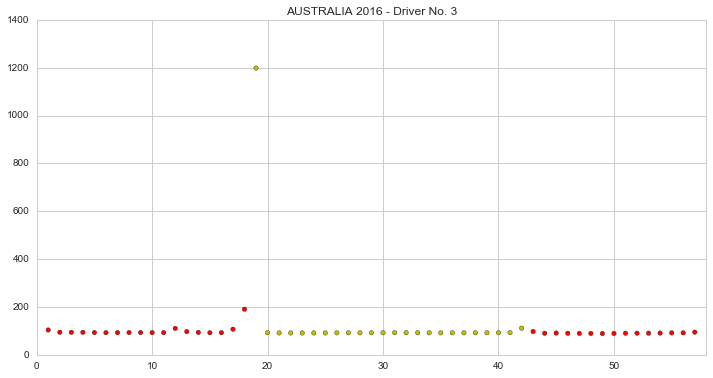

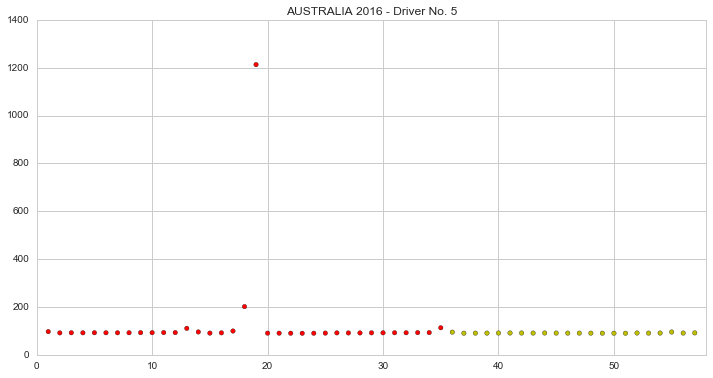

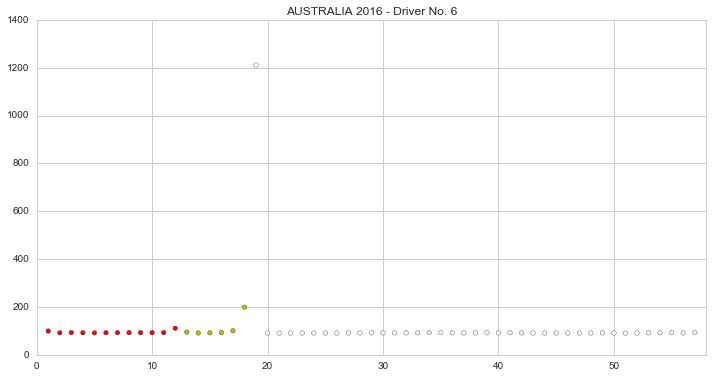

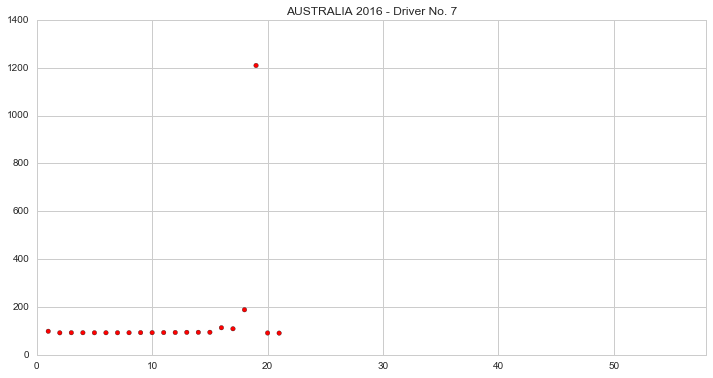

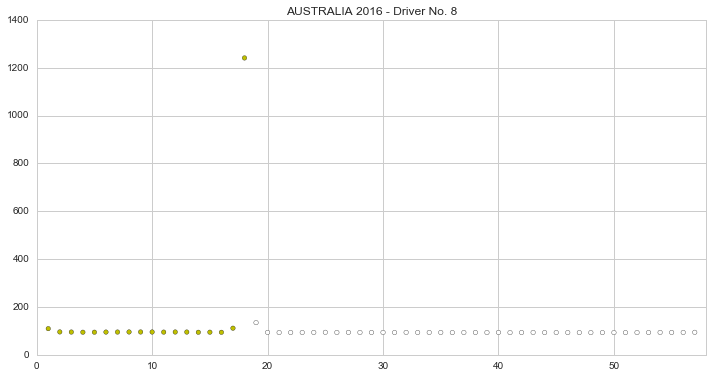

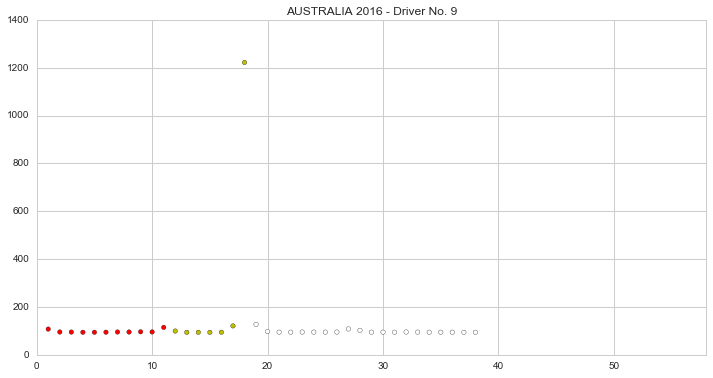

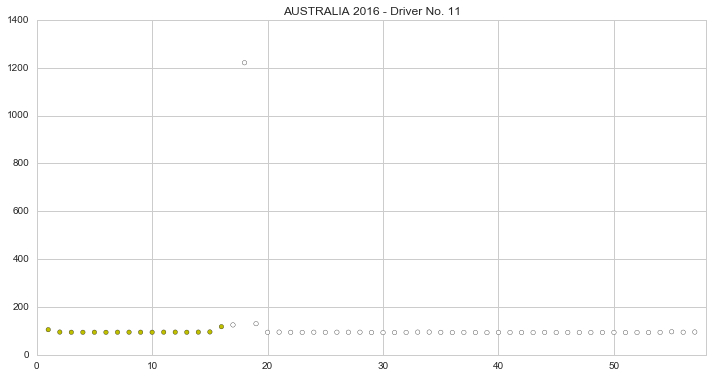

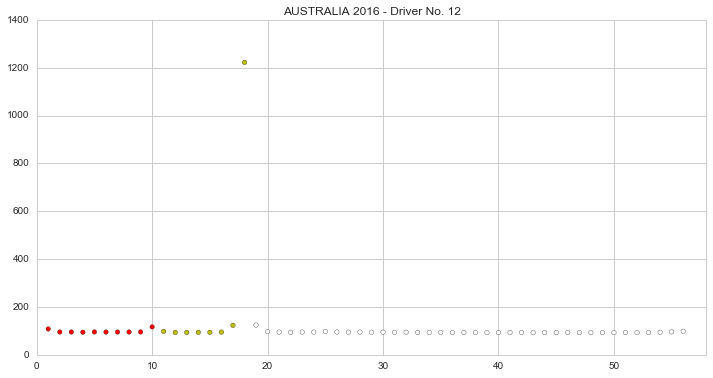

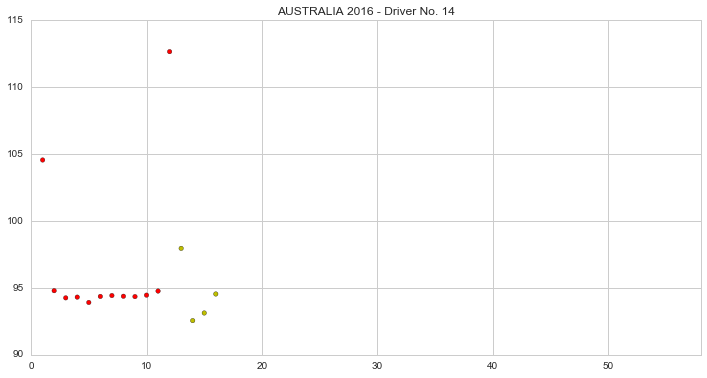

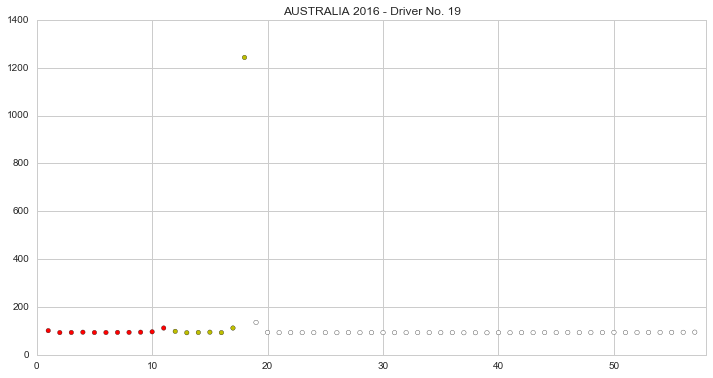

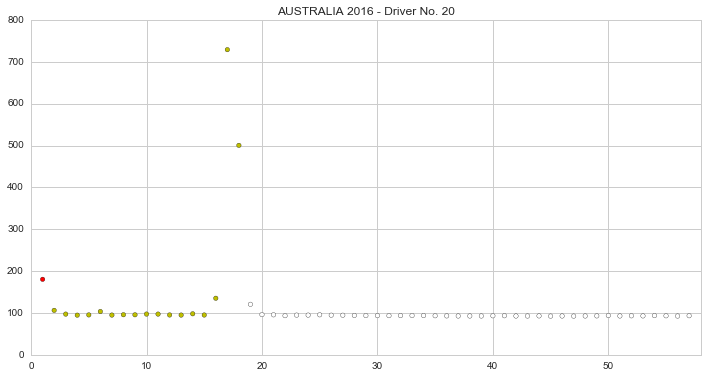

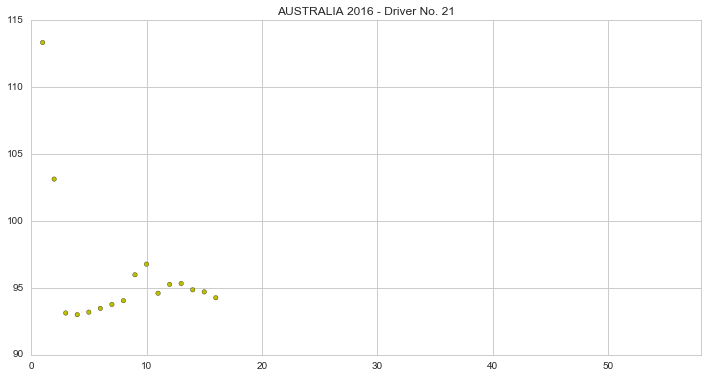

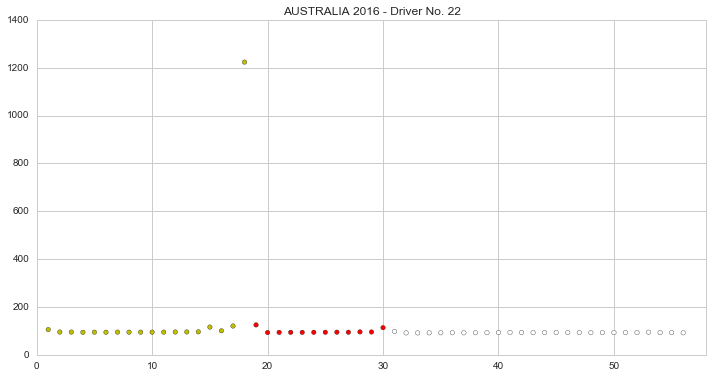

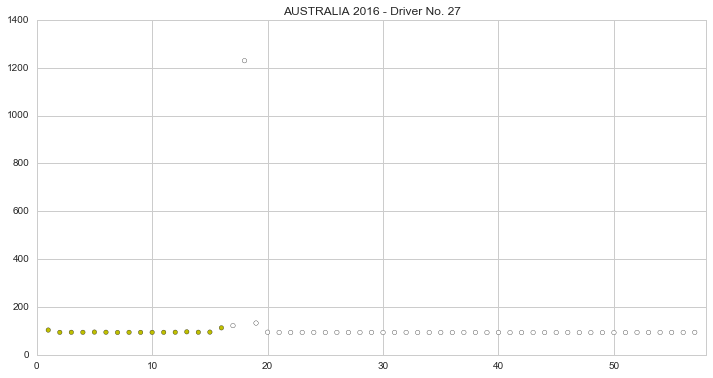

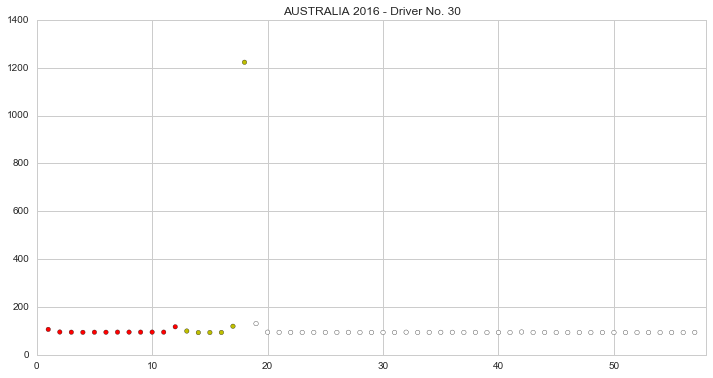

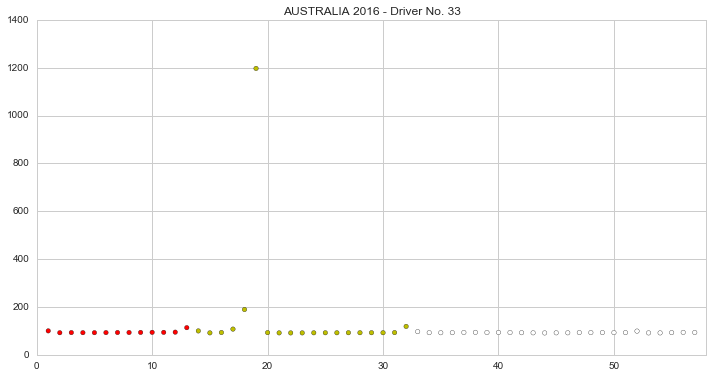

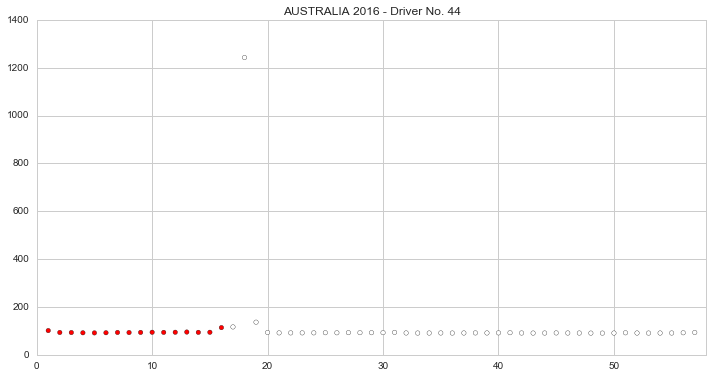

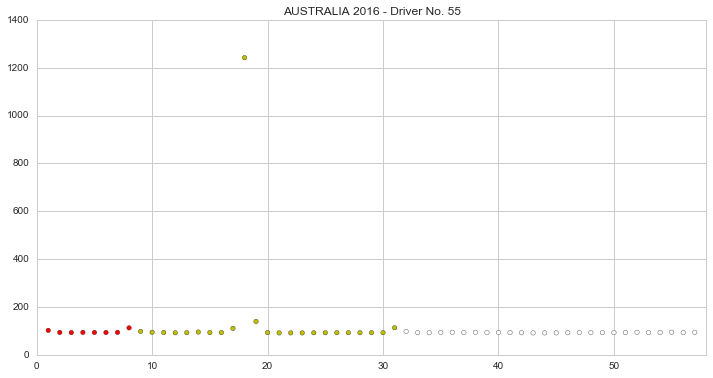

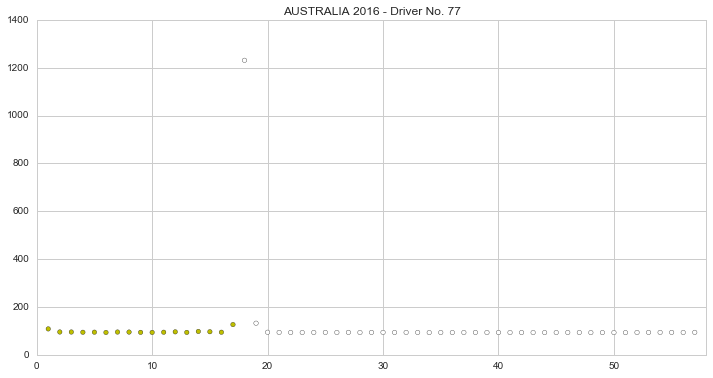

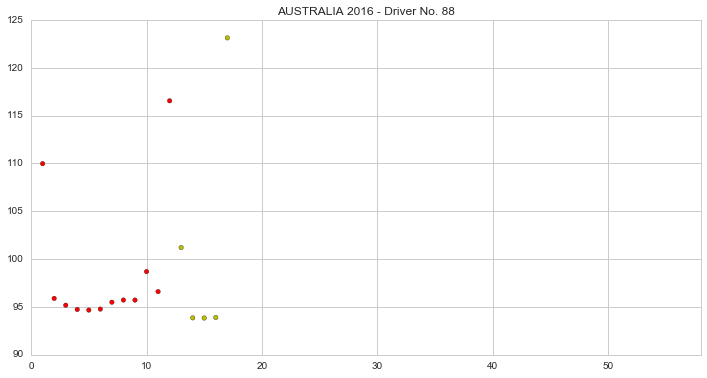

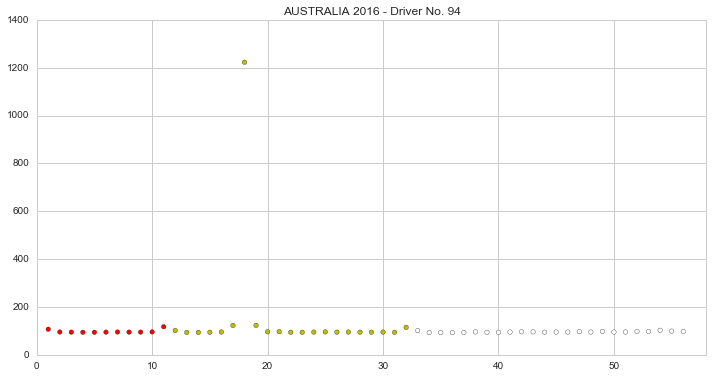

In [51]:
plot_drivers(all_lap_times, '2016_1_australia')

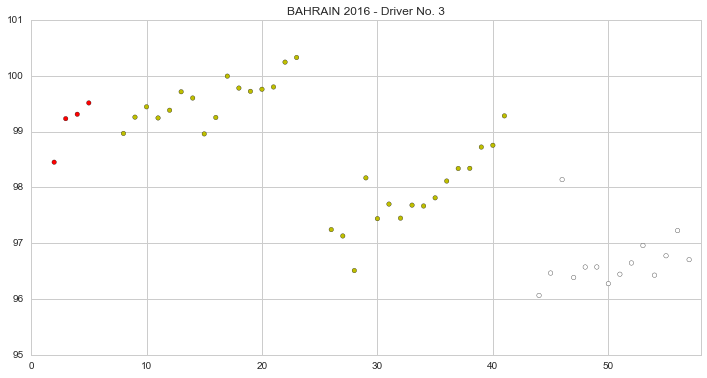

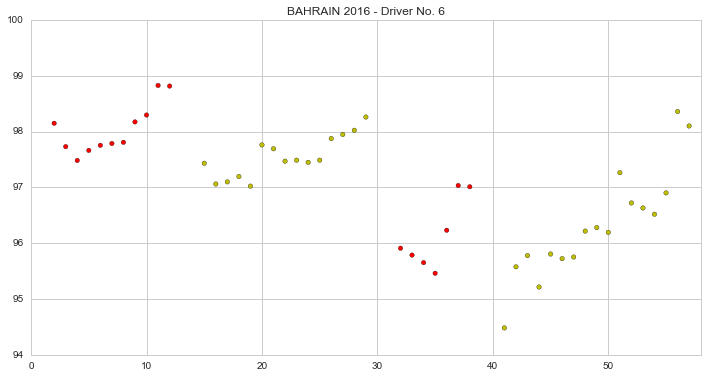

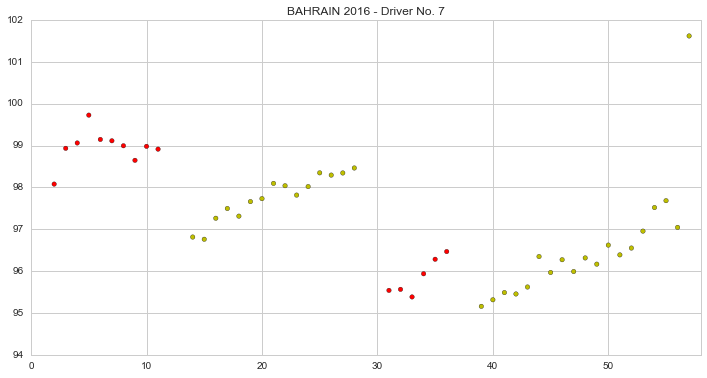

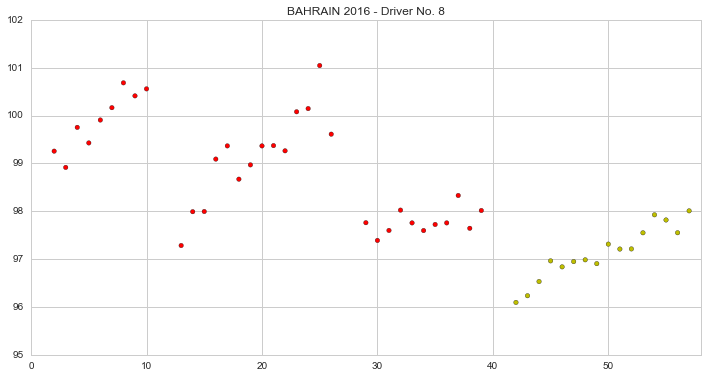

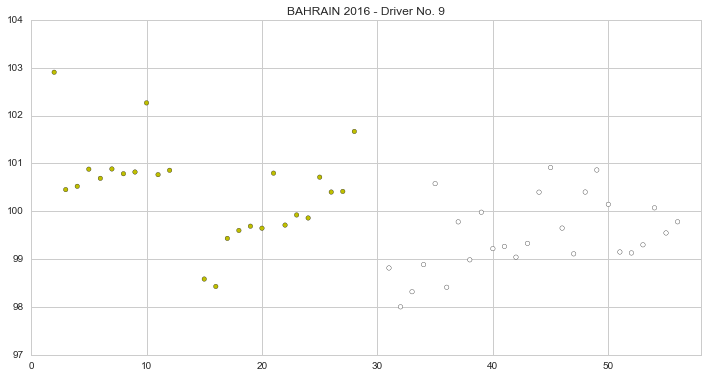

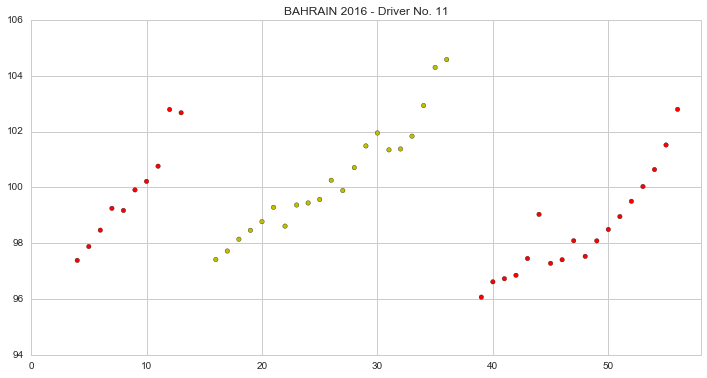

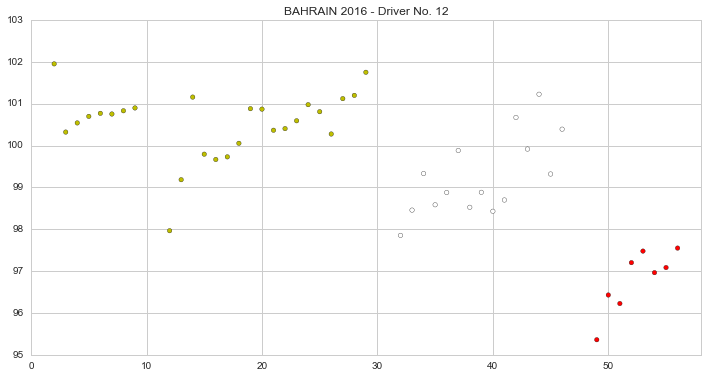

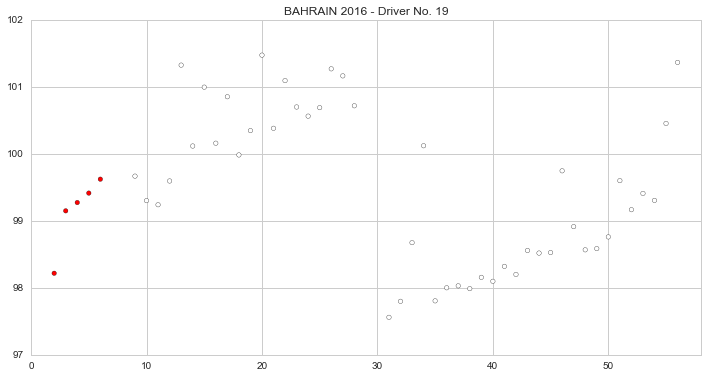

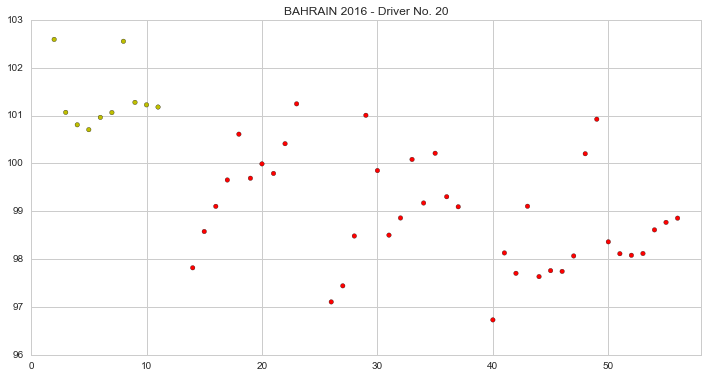

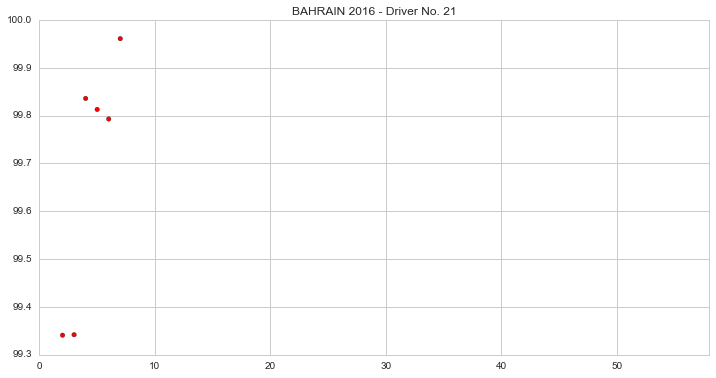

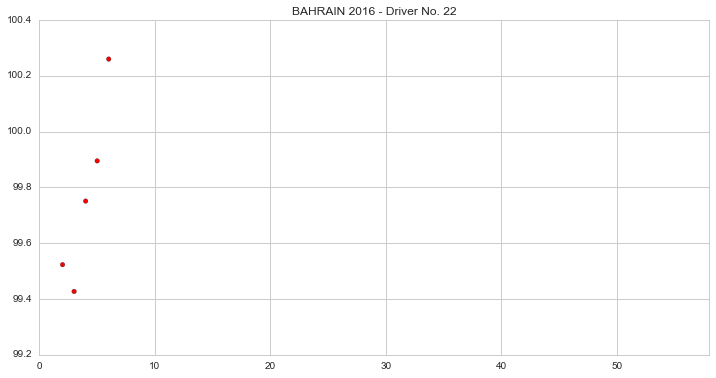

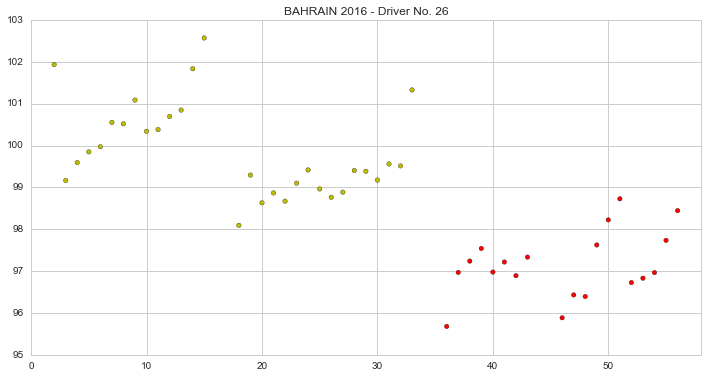

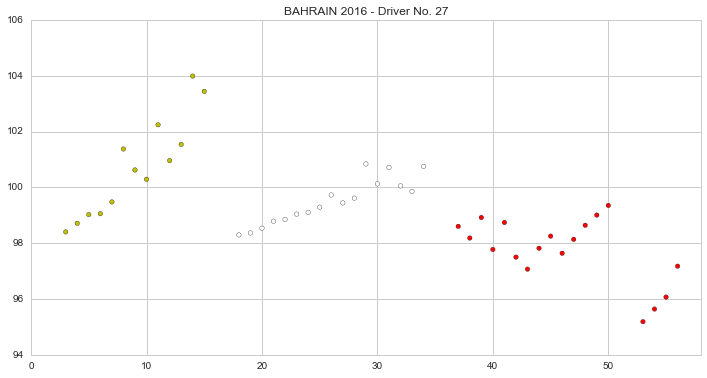

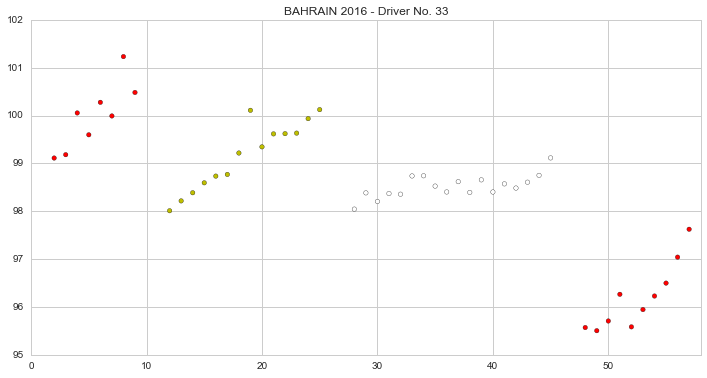

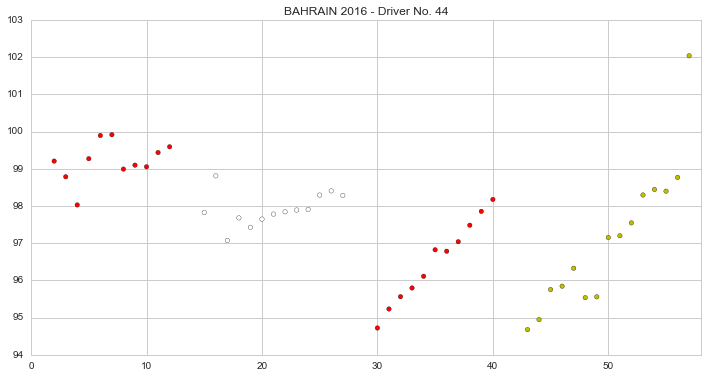

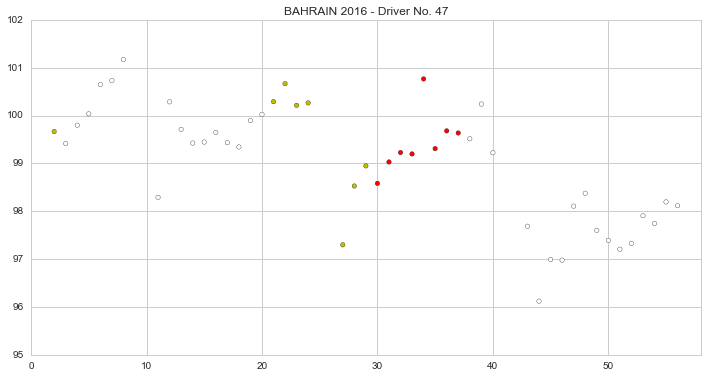

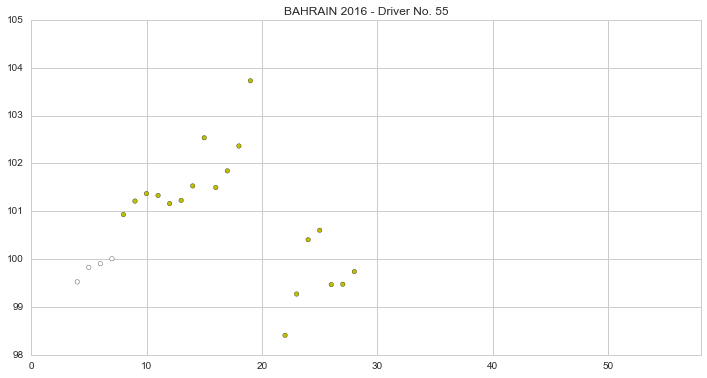

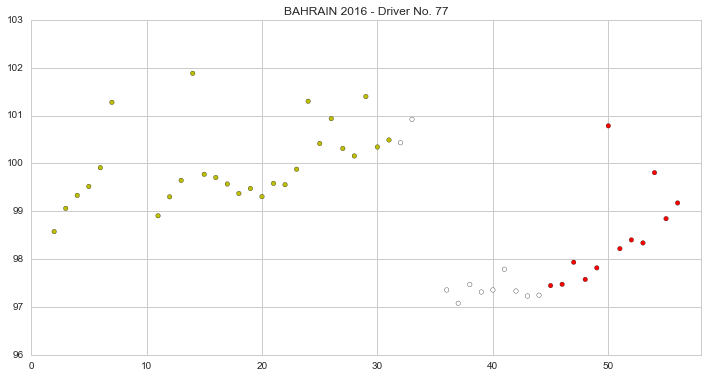

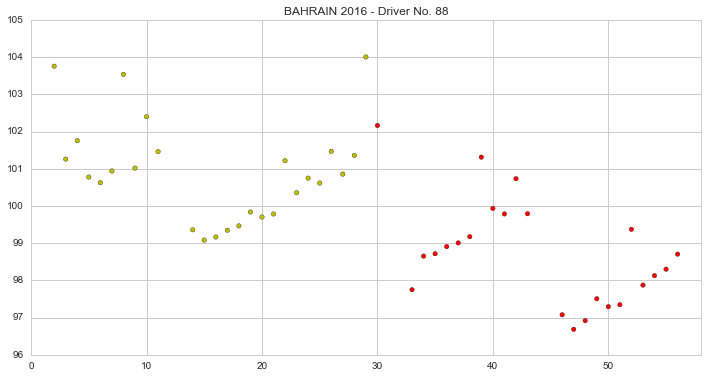

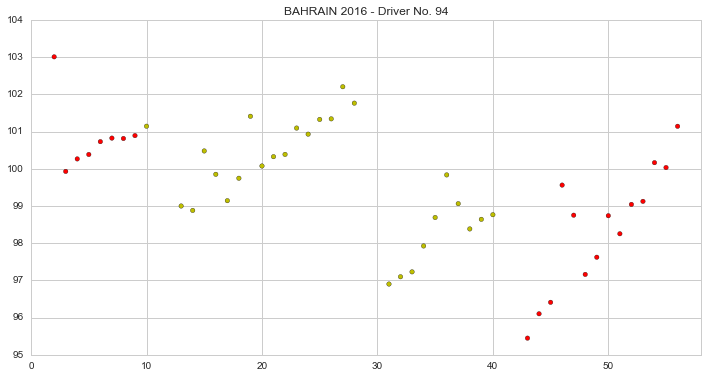

In [57]:
plot_drivers(no_safety, '2016_2_bahrain')

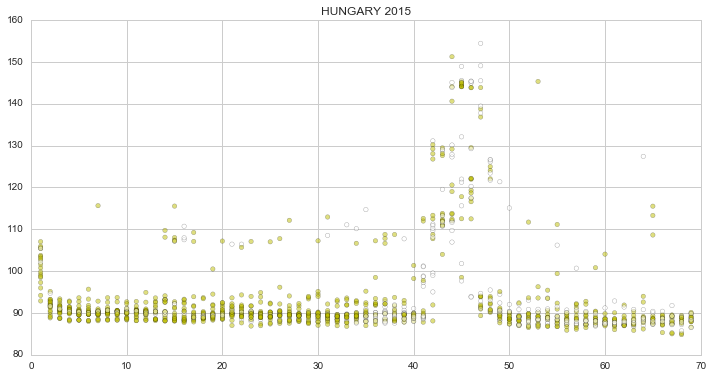

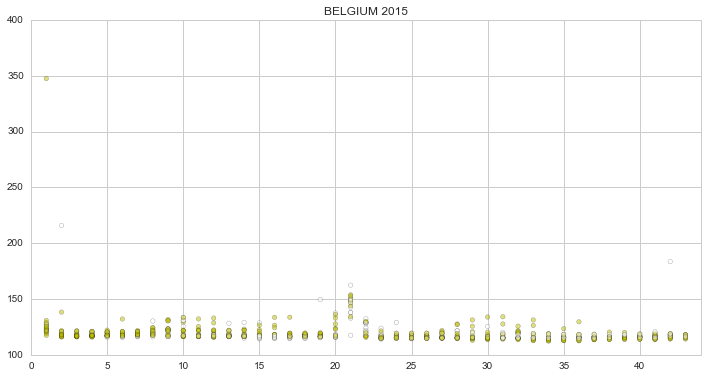

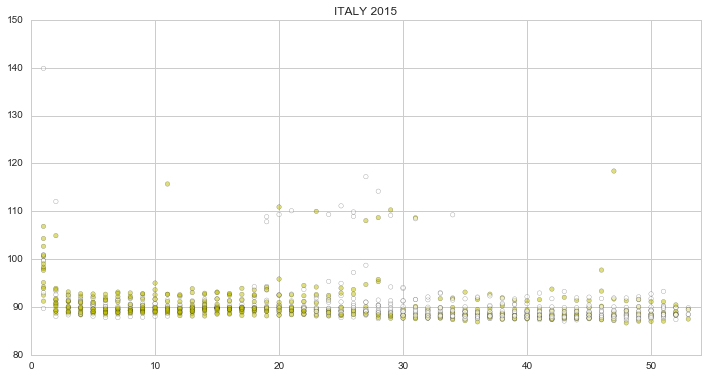

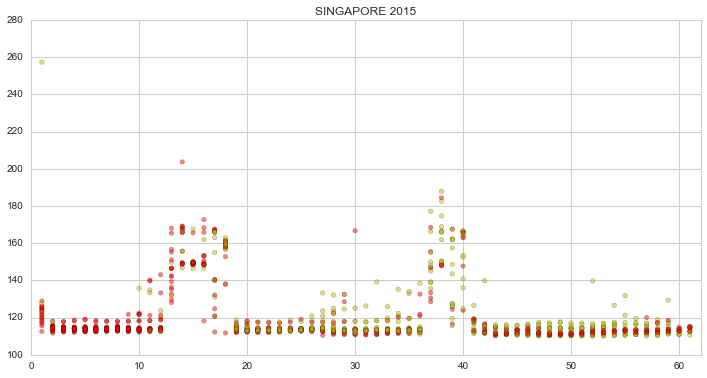

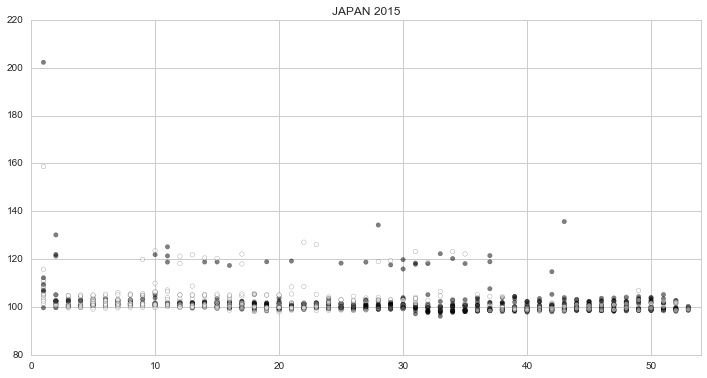

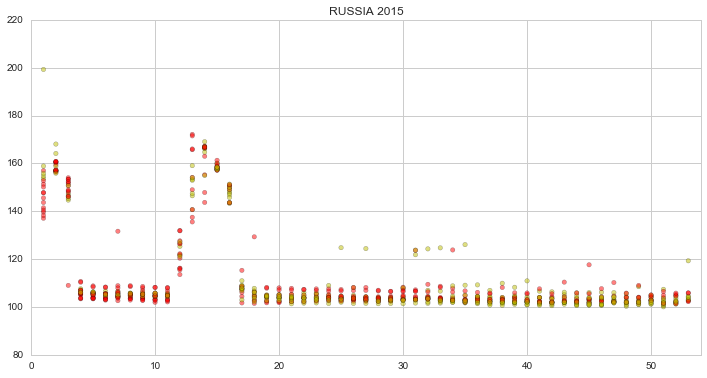

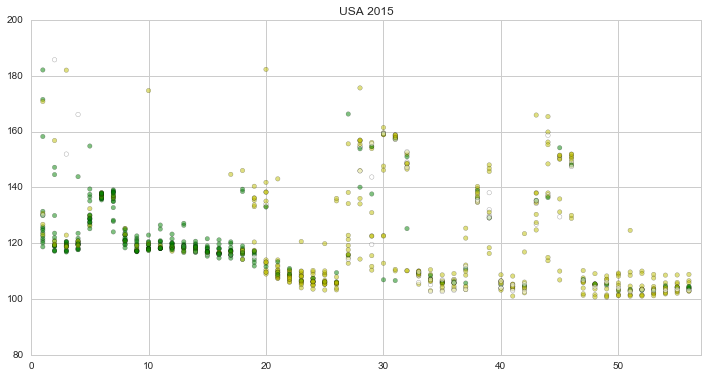

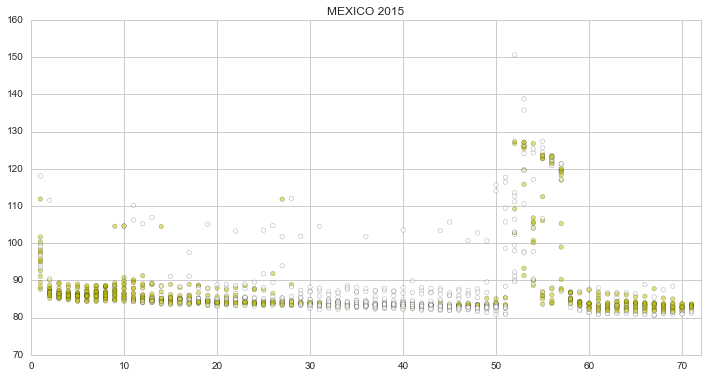

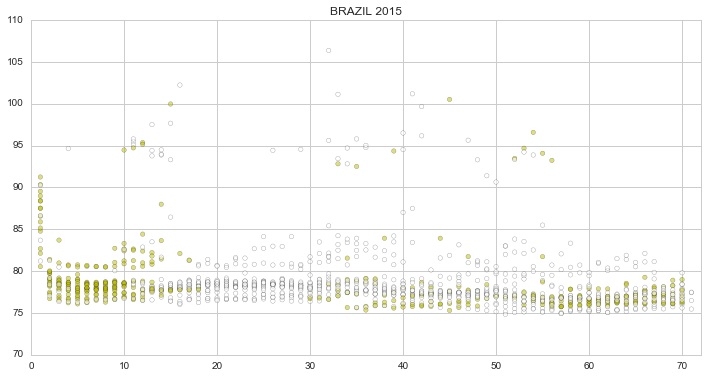

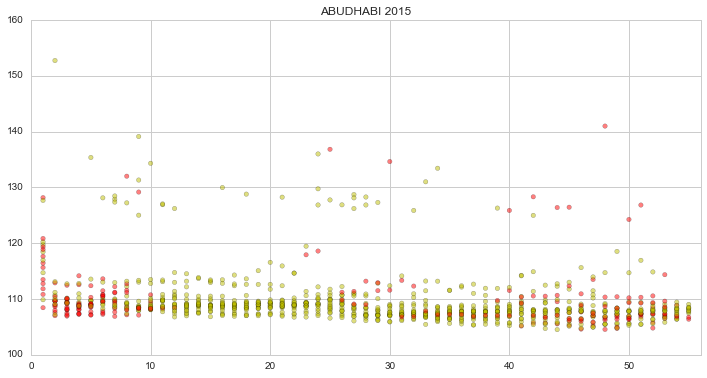

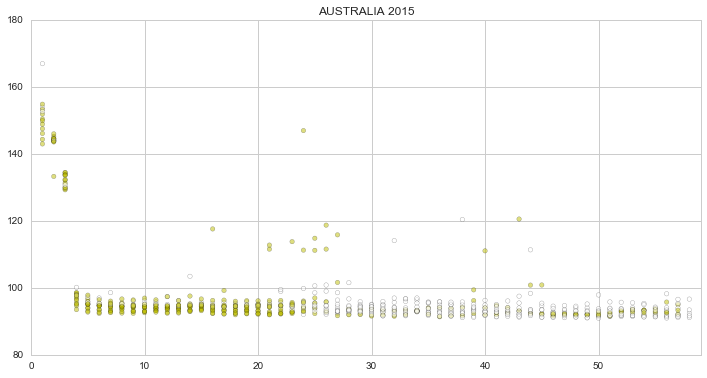

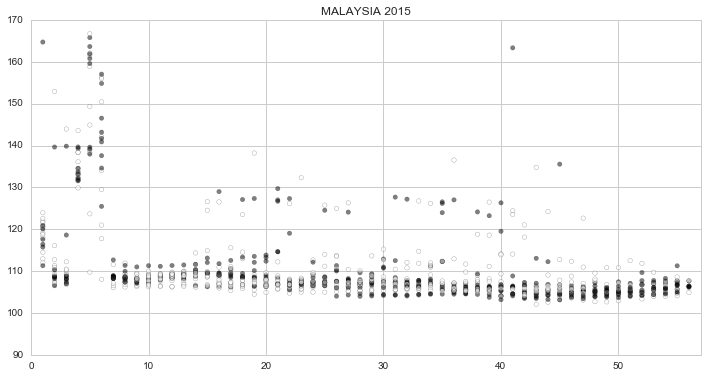

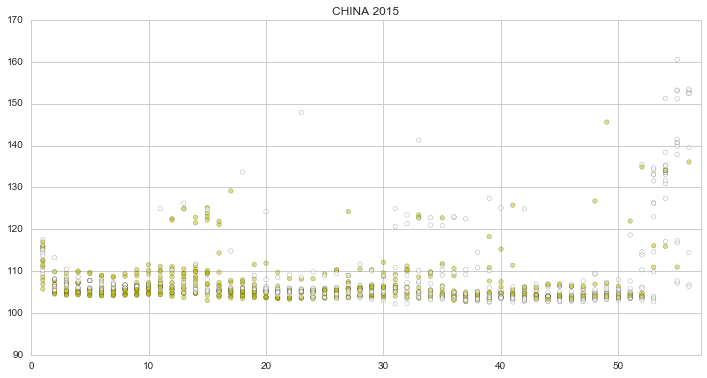

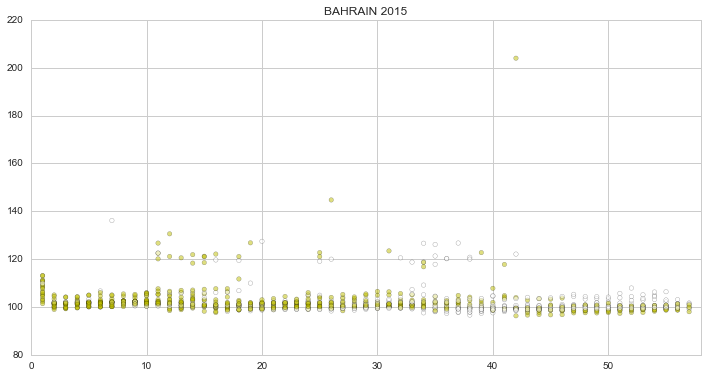

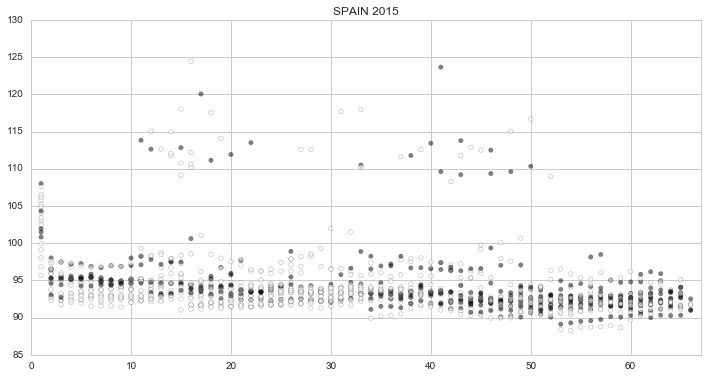

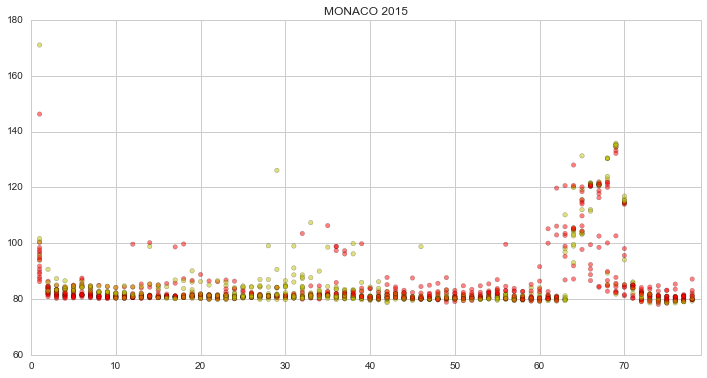

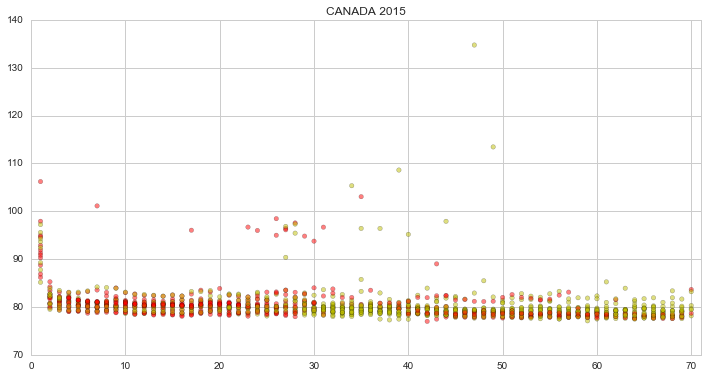

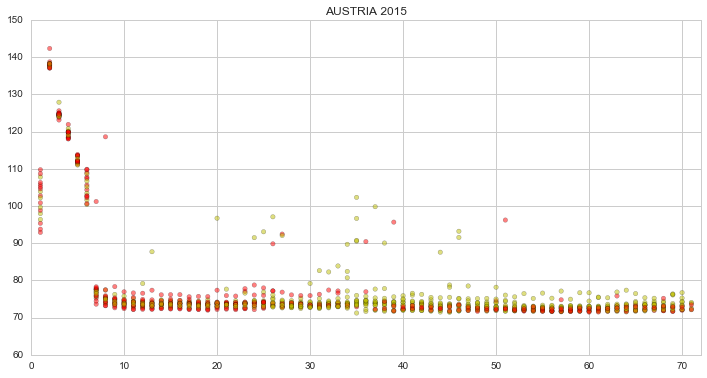

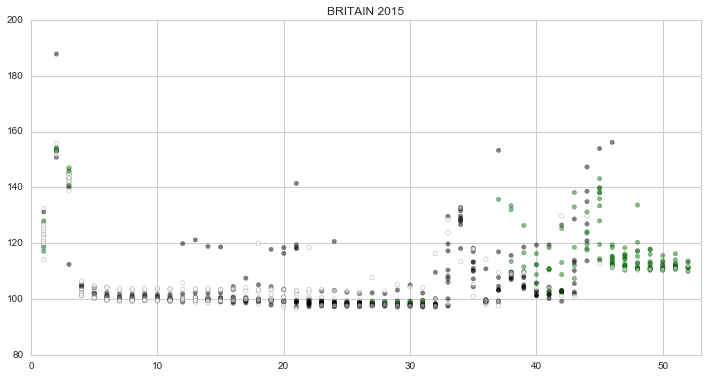

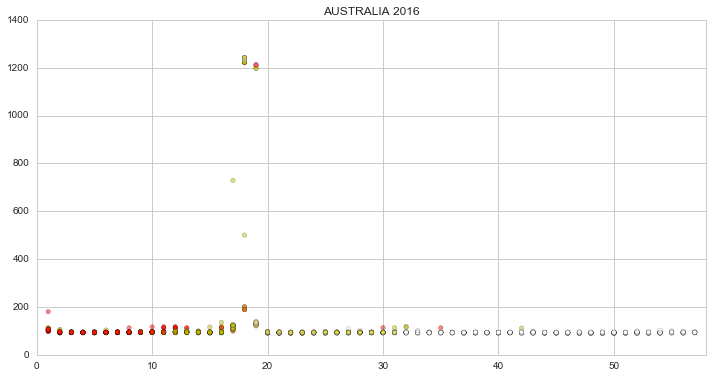

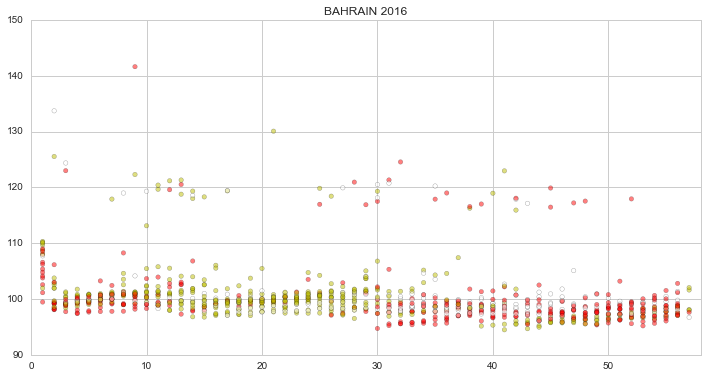

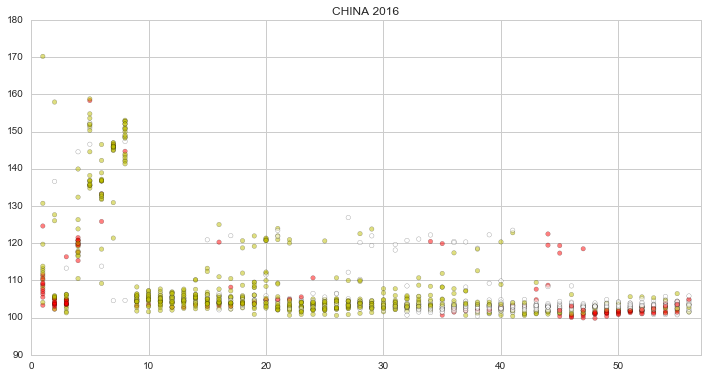

In [49]:
for race in races:
    plot_race(all_lap_times, race)

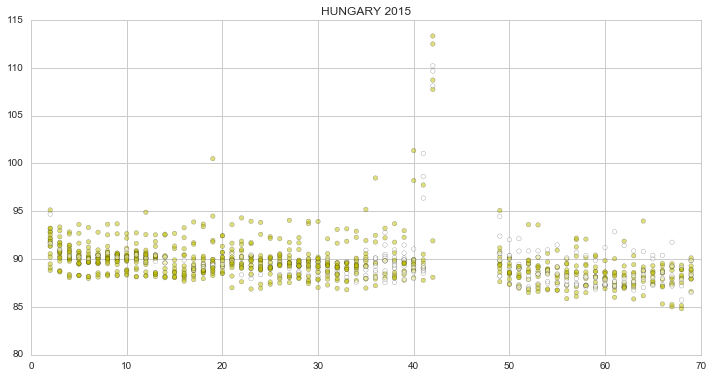

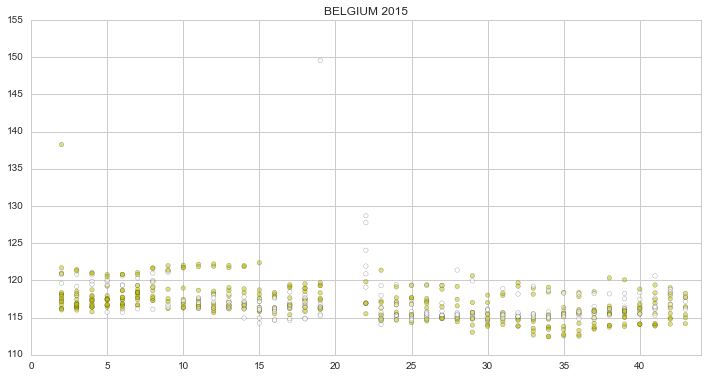

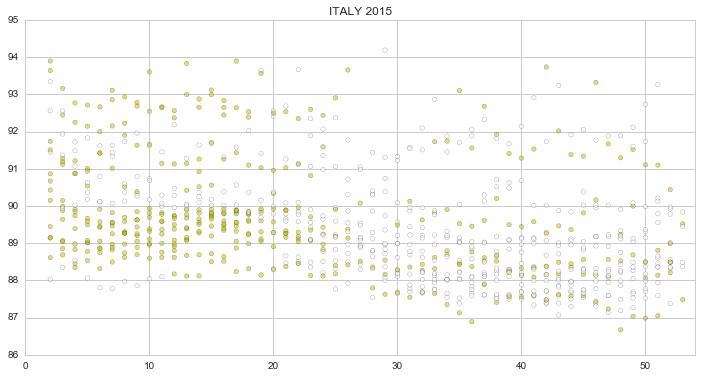

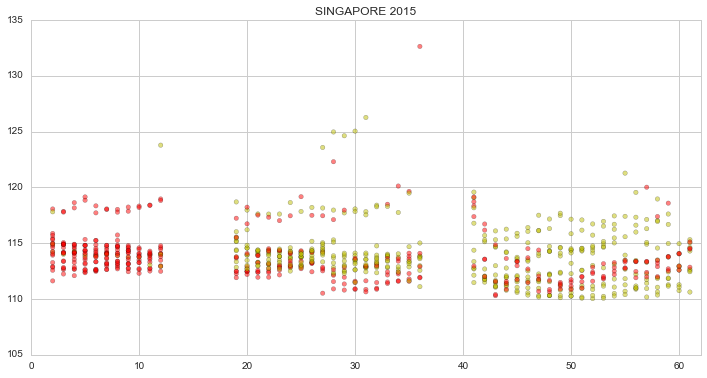

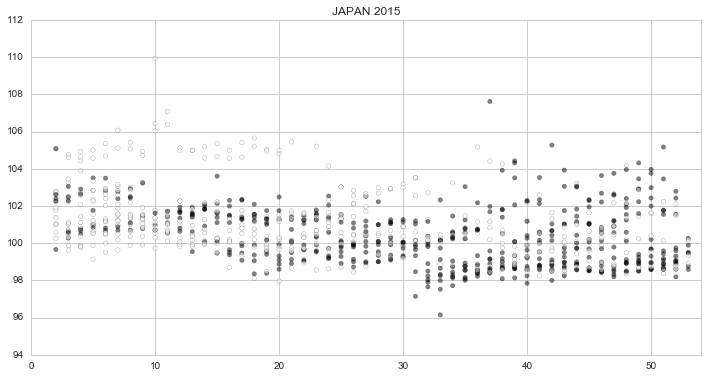

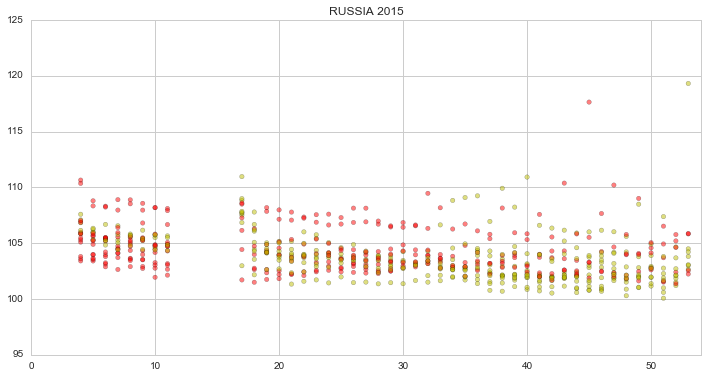

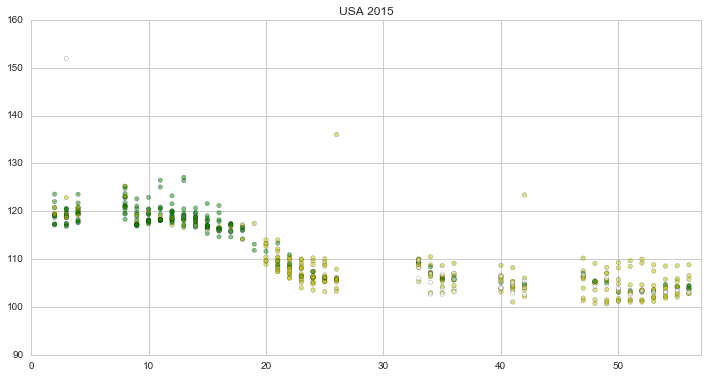

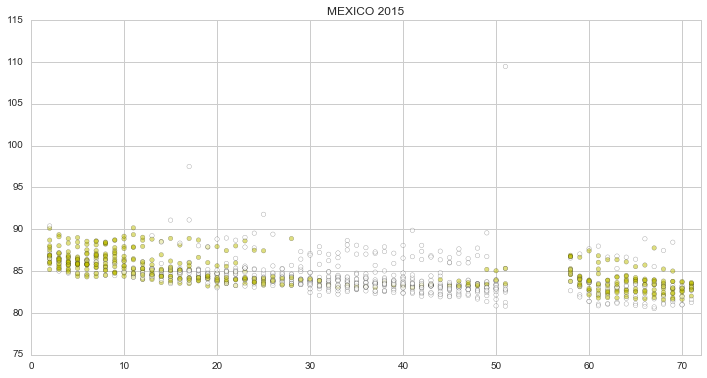

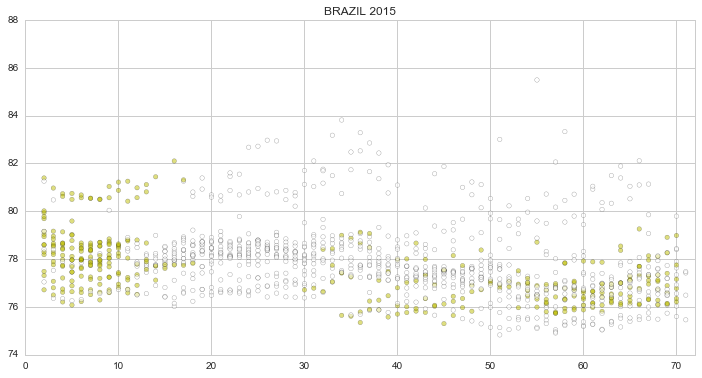

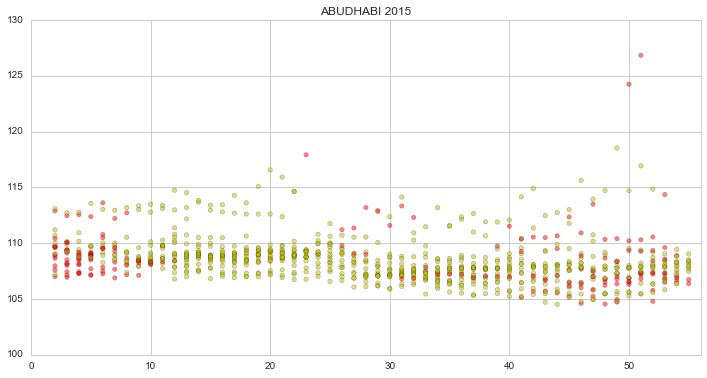

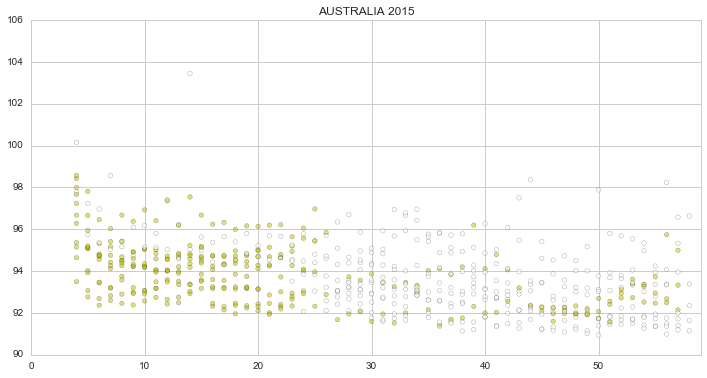

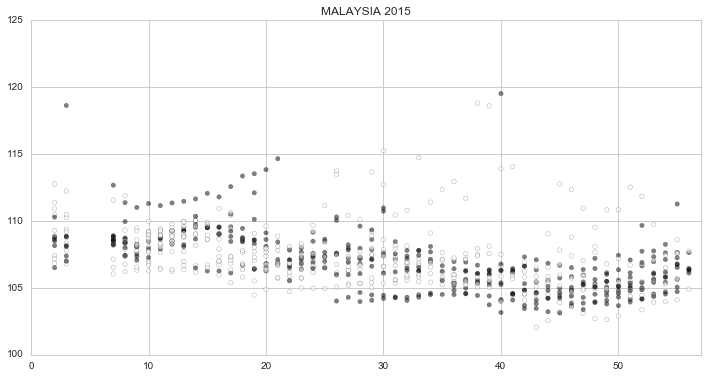

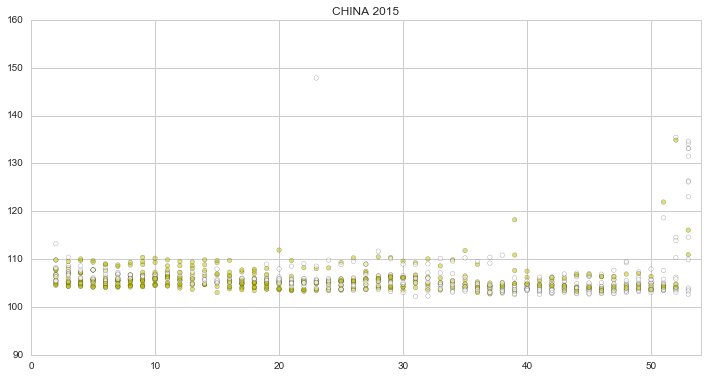

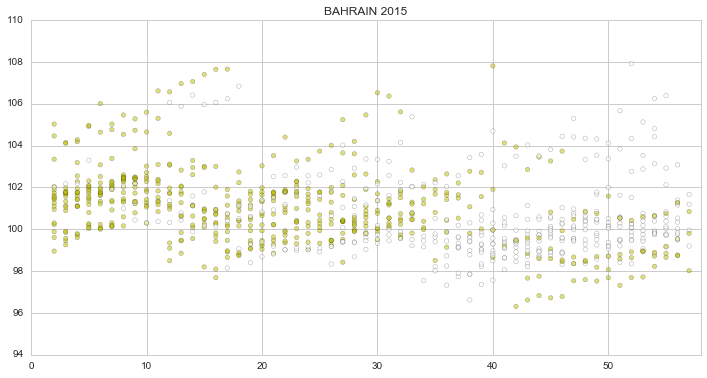

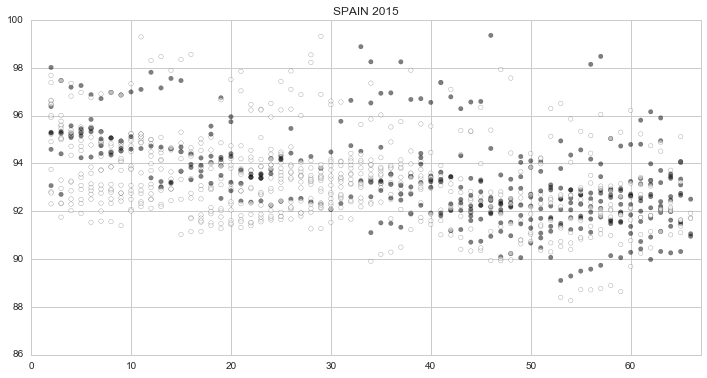

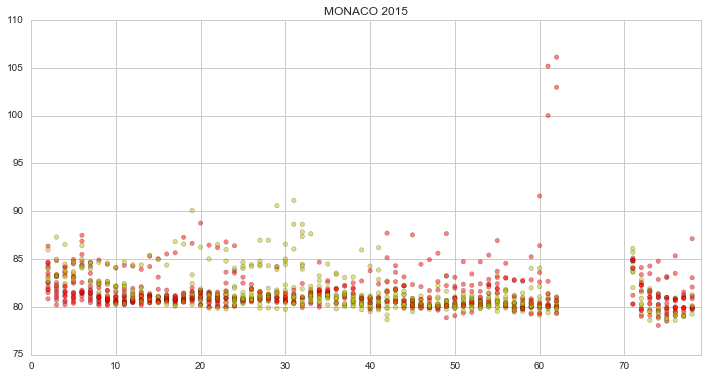

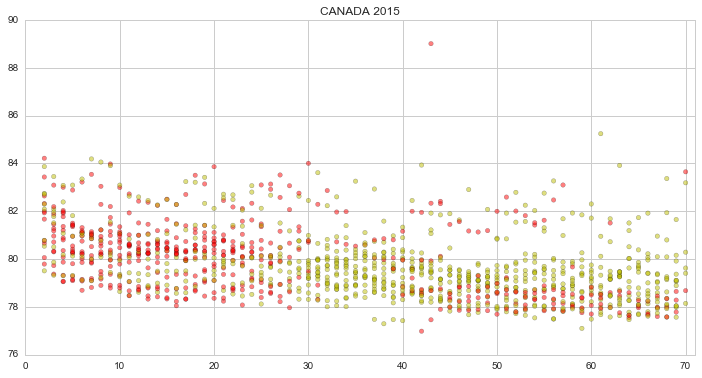

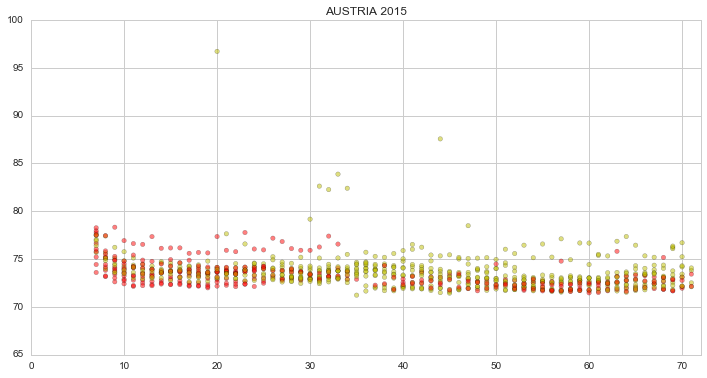

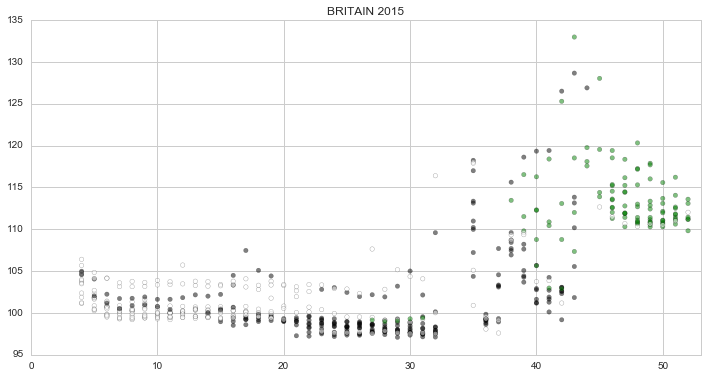

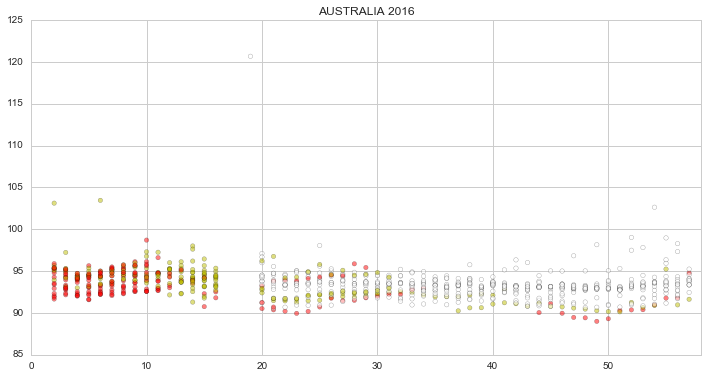

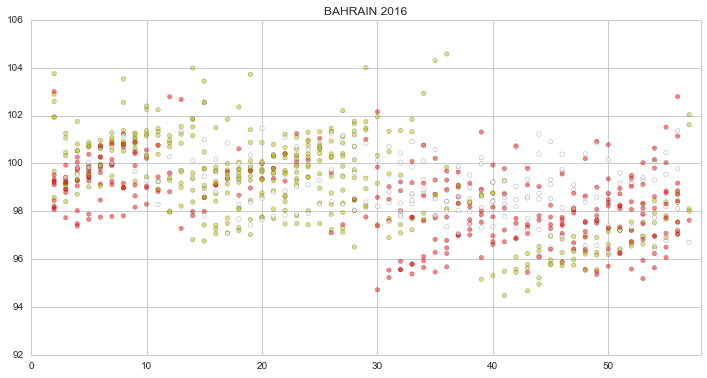

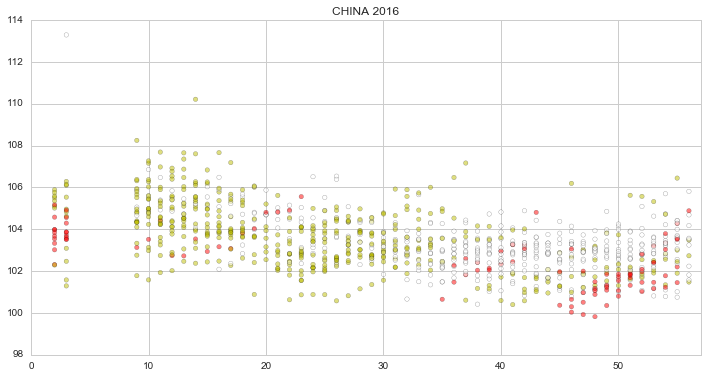

In [50]:
for race in races:
    plot_race(no_safety, race)

## TEST CODE BELOW

In [56]:
no_safety[(no_safety['NO'] == 20) & (no_safety['TRACK'] == 'australia') & (no_safety['YEAR'] == 2016)]

,NO,GAP,TIME,LAP,TIRE,TRACK,YEAR,RACE,SAFETY
20330,20,1 LAP,97.229,3,Soft,australia,2016,1,0
20331,20,1 LAP,94.720,4,Soft,australia,2016,1,0
20332,20,1 LAP,95.346,5,Soft,australia,2016,1,0
20333,20,1 LAP,103.453,6,Soft,australia,2016,1,0
20334,20,1 LAP,94.917,7,Soft,australia,2016,1,0
20335,20,1 LAP,95.742,8,Soft,australia,2016,1,0
20336,20,1 LAP,95.633,9,Soft,australia,2016,1,0
20337,20,1 LAP,97.304,10,Soft,australia,2016,1,0
20338,20,1 LAP,97.254,11,Soft,australia,2016,1,0
20339,20,1 LAP,95.206,12,Soft,australia,2016,1,0
